# Notebook for running multi-group sim with 8 groups for Cornell re-open

In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

## Importing Params, setting up group sim

In [2]:
ug_dorm_params = load_params('../src/simulations_v2/params/baseline_testing/august_5/ug_dorm.yaml')[1]
ug_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/august_5/ug_off_campus.yaml')[1]
gs_research_params = load_params('../src/simulations_v2/params/baseline_testing/august_5/grad_research.yaml')[1]
gs_other_params = load_params('../src/simulations_v2/params/baseline_testing/august_5/grad_other.yaml')[1]
faculty_staff_student_params = load_params('../src/simulations_v2/params/baseline_testing/august_5/faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params('../src/simulations_v2/params/baseline_testing/august_5/faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/august_5/faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params('../src/simulations_v2/params/baseline_testing/august_5/ithaca_community.yaml')[1]

/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/load_params.py:132: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/load_params.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [3]:
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [4]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [5]:
def run_multigroup_sim(sim, T):
    lockdown_statuses, sim_df = sim.run_new_trajectory(112)
    popsize = sim.get_total_population()
    infection_counts = sim_df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list, lockdown_statuses, list(infection_counts)

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    lockdown_trajectories = []
    infection_trajectories = []
    for _ in range(n):
        inf, hosp, lockdowns, infections = run_multigroup_sim(sim, T)
        inf_matrix.append(inf)
        hosp_matrix.append(hosp)
        lockdown_trajectories.append(lockdowns)
        infection_trajectories.append(infections)
    return inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories

In [6]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n,
                           post_lockdown_matrix, new_cases_threshold, new_cases_time_window,
                           procnum, return_dict):
    assert len(params_list) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    sim.configure_lockdown(post_lockdown_matrix, new_cases_threshold, new_cases_time_window)
    
    inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories = run_multiple_trajectories(sim, T, n)
    
    return_dict[procnum] = {
        'inf_matrix': inf_matrix,
        'hosp_matrix': hosp_matrix,
        'lockdown_trajectories': lockdown_trajectories,
        'infection_trajectories': infection_trajectories
    }

Note total population is 95892

In [7]:
def get_params_list_copy():
    return [ug_dorm_params.copy(), 
            ug_off_campus_params.copy(), 
            gs_research_params.copy(), 
            gs_other_params.copy(), 
            faculty_staff_student_params.copy(), 
            faculty_staff_non_student_params.copy(), 
            faculty_staff_off_campus_params.copy(), 
            ithaca_community_params.copy()]

In [8]:
import multiprocessing, time, itertools

# multiprocessing-tracking variables
manager = multiprocessing.Manager()
return_dict = manager.dict()
procnum = 0
procnum_to_params = {}
params_to_procnum = {}
jobs = []

# parameters to be simulated across each subprocess
test_policies = [[1/7,1/7,1/7,1/7,1/7,1/7,1/7,0]]
post_lockdown_matrix = 0.1 * interaction_matrix
new_cases_thresholds = [0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.02] # total population is 95892
new_cases_time_windows = [7, 14, 21, 28]
interaction_matrix_multipliers = [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3] # I am going to vary interaction matrix to get a sense of lockdown-sensitivity

# additional sim parameters
T = 112
nreps = 5 # bump this up if error bars are too large

# kick of new process for all combinations of above parameters

start_time = time.time()

for test_policy_idx, new_cases_thresh, new_cases_time, interaction_mult in itertools.product(
                                                                                range(len(test_policies)),
                                                                                new_cases_thresholds,
                                                                                new_cases_time_windows,
                                                                                interaction_matrix_multipliers):
    
    procnum_to_params[procnum] = (test_policy_idx, new_cases_thresh, new_cases_time, interaction_mult)
    params_to_procnum[(test_policy_idx, new_cases_thresh, new_cases_time, interaction_mult)] = procnum
    
    test_policy = test_policies[test_policy_idx]
    
    p = multiprocessing.Process(target = evaluate_testing_policy,
                               args = (get_params_list_copy(),
                                      interaction_mult * interaction_matrix,
                                      group_names,
                                      test_policy,
                                      T, 
                                      nreps,
                                      post_lockdown_matrix,
                                      new_cases_thresh,
                                      new_cases_time,
                                      procnum,
                                      return_dict))
    
    jobs.append(p)
    p.start()
    procnum += 1

print("Running simulations across {} processes".format(len(jobs)))
for proc in jobs:
    proc.join()
end_time = time.time()
print("Done running simulations. Elapsed time {:.2f} seconds".format(end_time - start_time))


Process Process-2:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-d5e6fd566cc3>", line 8, in evaluate_testing_policy
    sim.configure_lockdown(post_lockdown_matrix, new_cases_threshold, new_cases_time_window)
TypeError: configure_lockdown() missing 1 required positional argument: 'new_cases_time_window'
Process Process-3:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    s

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-d5e6fd566cc3>", line 8, in evaluate_testing_policy
    sim.configure_lockdown(post_lockdown_matrix, new_cases_threshold, new_cases_time_window)
TypeError: configure_lockdown() missing 1 required positional argument: 'new_cases_time_window'
Process Process-18:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-d5e6fd566cc3>", line 8, in evaluate_testing_policy
    sim.configure_lockdown(post_lockdown_matrix, new_cases_threshold, new_cases_time_window)
TypeError: configure_lockdown() missing 1 req

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
TypeError: configure_lockdown() missing 1 required positional argument: 'new_cases_time_window'
  File "<ipython-input-6-d5e6fd566cc3>", line 8, in evaluate_testing_policy
    sim.configure_lockdown(post_lockdown_matrix, new_cases_threshold, new_cases_time_window)
  File "<ipython-input-6-d5e6fd566cc3>", line 8, in evaluate_testing_policy
    sim.configure_lockdown(post_lockdown_matrix, new_cases_threshold, new_cases_time_window)
TypeError: configure_lockdown() missing 1 required positional argument: 'new_cases_time_window'
TypeError: configure_lockdown() missing 1 required positional argument: 'new_cases_time_window'
Process Process-33:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library

# below here is scrap and old code

In [19]:
a = [[1],[2]]
b = [1,2]
import itertools
list(itertools.product(a,b))
c = {}
c[([1],1)] = 23

TypeError: unhashable type: 'list'

In [11]:
sim = MultiGroupSimulation(params_list, interaction_matrix)

In [12]:
lockdown_statuses, sim_df = sim.run_new_trajectory(10)

In [14]:
popsize = sim.get_total_population()
infection_counts = sim_df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1)
infection_counts

0     0.108455
1     0.117841
2     0.135569
3     0.154340
4     0.164769
5     0.178326
6     0.191883
7     0.206482
8     0.223168
9     0.245067
10    0.271138
dtype: float64

In [15]:
list(infection_counts)

[0.10845534559713012,
 0.1178409043507279,
 0.13556918199641263,
 0.15434029950360822,
 0.1647686981187169,
 0.17832561631835814,
 0.19188253451799941,
 0.20648229257915154,
 0.2231677303633254,
 0.24506736745505361,
 0.27113836399282526]

In [10]:
testing_results = list()
for policy in [[1/7,1/7,1/7,1/7,1/7,1/7,1/7,0]]:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 5)
    testing_results.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0]
> <ipython-input-9-07e74144e0b8>(18)evaluate_testing_policy()
-> inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
(Pdb) sim.get_total_population()
95892
(Pdb) exit()


BdbQuit: 

In [7]:
def generate_plotting_matrix(results_list):
    daily_tests = list()
    inf = list()
    inf_low = list()
    inf_high = list()
    hosp = list()
    hosp_low = list()
    hosp_high = list()
    cornell_inf = list()
    cornell_inf_low = list()
    cornell_inf_high = list()
    cornell_hosp = list()
    cornell_hosp_low = list()
    cornell_hosp_high = list()

    policy_ug_dorm = list()
    policy_ug_off_campus = list()
    policy_grad_research = list()
    policy_grad_other = list()
    policy_staff_student = list()
    policy_staff_non_student = list()
    policy_staff_off_campus = list()
    
    policies = list()
    
    for policy_dict in results_list:
        daily_tests.append(policy_dict['tests_per_day'])
        inf.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.5, axis=0))
        inf_low.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.1, axis=0))
        inf_high.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.9, axis=0))
        hosp.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.5, axis=0))
        hosp_low.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.1, axis=0))
        hosp_high.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.9, axis=0))

        cornell_inf.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.5, axis=0))
        cornell_inf_low.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.1, axis=0))
        cornell_inf_high.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.9, axis=0))
        cornell_hosp.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.5, axis=0))
        cornell_hosp_low.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.1, axis=0))
        cornell_hosp_high.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.9, axis=0))

        policy_ug_dorm.append(int(policy_dict['test_policy'][0]*7))
        policy_ug_off_campus.append(int(policy_dict['test_policy'][1]*7))
        policy_grad_research.append(int(policy_dict['test_policy'][2]*7))
        policy_grad_other.append(int(policy_dict['test_policy'][3]*7))
        policy_staff_student.append(int(policy_dict['test_policy'][4]*7))
        policy_staff_non_student.append(int(policy_dict['test_policy'][5]*7))
        policy_staff_off_campus.append(policy_dict['test_policy'][6]*7)
        
        test_policy_string = '['
        for frequency in policy_dict['test_policy'][:-2]:
            test_policy_string += str(int(frequency * 7)) + ','
        test_policy_string += str(np.round(policy[-2] * 7, 2))
        test_policy_string += ']'
        policies.append(test_policy_string)

    plotting_data = pd.DataFrame({'daily_tests': daily_tests, 'inf': inf, 'inf_low': inf_low, 'inf_high': inf_high, 'hosp': hosp,
                  'hosp_low': hosp_low, 'hosp_high': hosp_high, 'cornell_inf': cornell_inf, 'cornell_inf_low': cornell_inf_low,
                  'cornell_inf_high': cornell_inf_high, 'cornell_hosp': cornell_hosp, 'cornell_hosp_low': cornell_hosp_low,
                  'cornell_hosp_high': cornell_hosp_high, 'test_policy_ug_dorm': policy_ug_dorm,
                  'test_policy_ug_off_campus': policy_ug_off_campus,
                  'test_policy_grad_research': policy_grad_research, 'test_policy_grad_other': policy_grad_other,
                  'test_policy_staff_student': policy_staff_student,
                  'test_policy_staff_non_student': policy_staff_non_student,
                  'test_policy_staff_off_campus': policy_staff_off_campus,
                  'test_policy': policies})

    plotting_data['inf_yerr_low'] = plotting_data['inf'] - plotting_data['inf_low']
    plotting_data['inf_yerr_high'] = plotting_data['inf_high'] - plotting_data['inf']
    plotting_data['hosp_yerr_low'] = plotting_data['hosp'] - plotting_data['hosp_low']
    plotting_data['hosp_yerr_high'] = plotting_data['hosp_high'] - plotting_data['hosp']
    plotting_data['cornell_inf_yerr_low'] = plotting_data['cornell_inf'] - plotting_data['cornell_inf_low']
    plotting_data['cornell_inf_yerr_high'] = plotting_data['cornell_inf_high'] - plotting_data['cornell_inf']
    plotting_data['cornell_hosp_yerr_low'] = plotting_data['cornell_hosp'] - plotting_data['cornell_hosp_low']
    plotting_data['cornell_hosp_yerr_high'] = plotting_data['cornell_hosp_high'] - plotting_data['cornell_hosp']
    return plotting_data

In [8]:
def plot_policy_performance(plotting_data):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['inf'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Infections vs. Daily tests for various policies')
    plt.ylabel('Infections')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data['hosp_yerr_low'],plotting_data['hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['hosp'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Hospitalizations vs. Daily tests for various policies')
    plt.ylabel('Hospitalizations')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data['cornell_inf_yerr_low'],plotting_data['cornell_inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['cornell_inf'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Cornell Infections vs. Daily tests for various policies')
    plt.ylabel('Cornell Infections')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10,6))
    plt.errorbar(x='daily_tests', y='cornell_hosp', yerr = [plotting_data['cornell_hosp_yerr_low'],plotting_data['cornell_hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['cornell_hosp'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
    plt.ylabel('Cornell Hospitalizations')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()

## Testing evaluate_testing_policy 

In [9]:
testing_results = list()
for policy in [[1/7,1/7,1/7,1/7,1/7,1/7,1/7,0]]:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 5)
    testing_results.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0]


In [10]:
plotting_data = generate_plotting_matrix(testing_results)
plotting_data

,daily_tests,inf,inf_low,inf_high,hosp,hosp_low,hosp_high,cornell_inf,cornell_inf_low,cornell_inf_high,...,test_policy_staff_off_campus,test_policy,inf_yerr_low,inf_yerr_high,hosp_yerr_low,hosp_yerr_high,cornell_inf_yerr_low,cornell_inf_yerr_high,cornell_hosp_yerr_low,cornell_hosp_yerr_high
0,4841.714286,6317.0,6008.4,6969.8,70.614876,66.672683,76.304548,5763.0,5495.6,6462.2,...,1.0,"[1,1,1,1,1,1,1.0]",308.6,652.8,3.942193,5.689672,267.4,699.2,3.179626,6.929647


## Baseline Matrix

In [11]:
limited_policies = [[1/7,1/7,1/7,1/7,1/7,1/7,1/14,0],
[2/7,1/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,2/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,2/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,2/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,1/7,2/7,1/30,0],
[2/7,2/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,2/7,2/7,1/7,2/7,1/7,1/30,0],
[2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]]

In [12]:
results_baseline = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 50)
    results_baseline.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857

In [15]:
plotting_data = generate_plotting_matrix(results_baseline)
plotting_data

,daily_tests,inf,inf_low,inf_high,hosp,hosp_low,hosp_high,cornell_inf,cornell_inf_low,cornell_inf_high,...,test_policy_staff_off_campus,test_policy,inf_yerr_low,inf_yerr_high,hosp_yerr_low,hosp_yerr_high,cornell_inf_yerr_low,cornell_inf_yerr_high,cornell_hosp_yerr_low,cornell_hosp_yerr_high
0,4500.428571,6981.0,5899.7,7679.5,75.947980,64.582096,84.385141,6433.0,5432.9,7062.1,...,0.500000,"[1,1,1,1,1,1,0.23]",1081.3,698.5,11.365883,8.437161,1000.1,629.1,9.397991,6.457574
1,5306.980952,2279.5,1861.6,2740.2,28.285322,23.923406,33.922852,1934.0,1545.6,2314.5,...,0.233333,"[2,1,1,1,1,1,0.23]",417.9,460.7,4.361916,5.637531,388.4,380.5,3.703730,3.648980
2,6467.409524,1402.5,1095.9,1710.3,19.453424,15.898088,22.124985,1085.0,792.6,1369.1,...,0.233333,"[2,2,1,1,1,1,0.23]",306.6,307.8,3.555335,2.671561,292.4,284.1,2.610178,2.790302
3,5827.695238,2287.5,1829.7,2502.0,27.923283,23.743273,31.352044,1947.0,1510.9,2187.4,...,0.233333,"[2,1,2,1,1,1,0.23]",457.8,214.5,4.180010,3.428761,436.1,240.4,3.928907,2.764938
4,6009.980952,2048.0,1759.3,2566.2,26.042338,22.240637,32.995521,1709.0,1442.8,2163.9,...,0.233333,"[2,1,1,2,1,1,0.23]",288.7,518.2,3.801701,6.953184,266.2,454.9,3.009126,4.845271
5,5820.980952,2118.5,1805.9,2503.6,27.077219,23.502958,30.346059,1792.5,1518.5,2120.0,...,0.233333,"[2,1,1,1,2,1,0.23]",312.6,385.1,3.574261,3.268840,274.0,327.5,3.004438,2.755574
6,5579.409524,2318.5,1821.8,2595.5,29.171103,24.180482,32.364334,1961.5,1508.8,2223.1,...,0.233333,"[2,1,1,1,1,2,0.23]",496.7,277.0,4.990621,3.193231,452.7,261.6,3.986511,2.874927
7,7170.409524,1148.0,949.7,1466.9,16.524436,14.145359,20.817051,867.5,669.4,1122.3,...,0.233333,"[2,2,1,2,1,1,0.23]",198.3,318.9,2.379077,4.292615,198.1,254.8,2.198396,2.639917
8,7502.123810,1233.5,962.0,1509.5,17.131446,14.361273,19.813497,953.5,680.0,1224.8,...,0.233333,"[2,2,2,1,2,1,0.23]",271.5,276.0,2.770173,2.682051,273.5,271.3,2.484875,2.055855
9,7684.409524,1099.0,882.3,1335.7,16.208260,13.905392,19.111958,799.5,605.2,1054.4,...,0.233333,"[2,2,1,2,2,1,0.23]",216.7,236.7,2.302868,2.903698,194.3,254.9,1.888375,2.478344


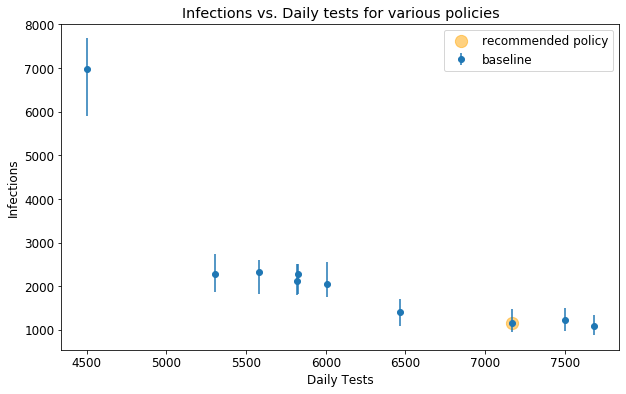

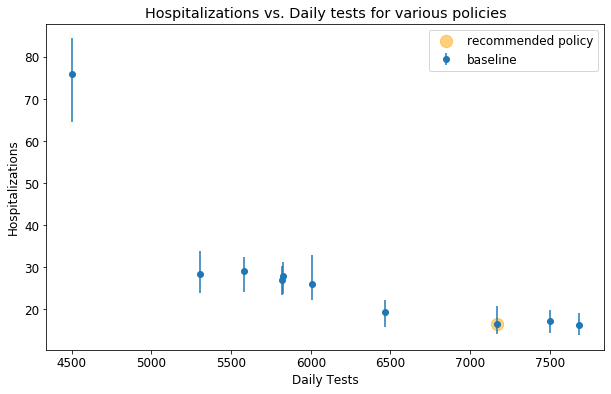

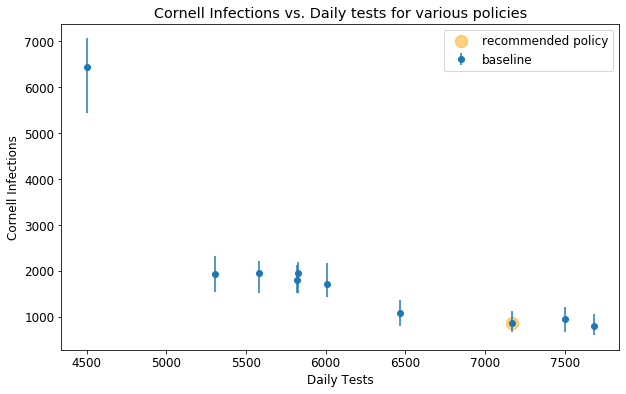

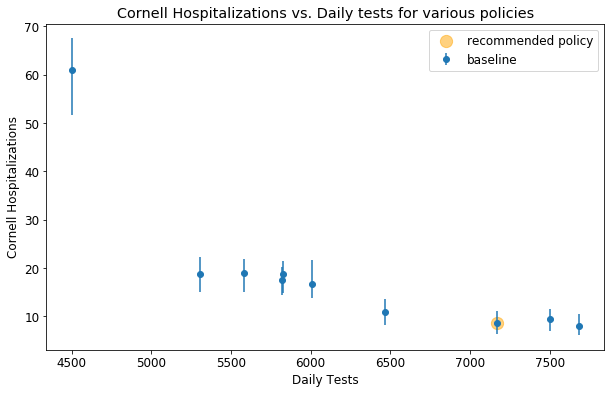

In [17]:
plot_policy_performance(plotting_data)

## Increasing Contacts between faculty/staff and Ithaca

In [9]:
interaction_matrix_v2 = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,3],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,3],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,3],
                               [0.011,0.026,0.106,0.016,0.174,0.092,0.231,3.5]])

results_faculty_ithaca = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix_v2, group_names, policy, 112, 50)
    results_faculty_ithaca.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857

In [27]:
plotting_data = generate_plotting_matrix(results_faculty_ithaca)

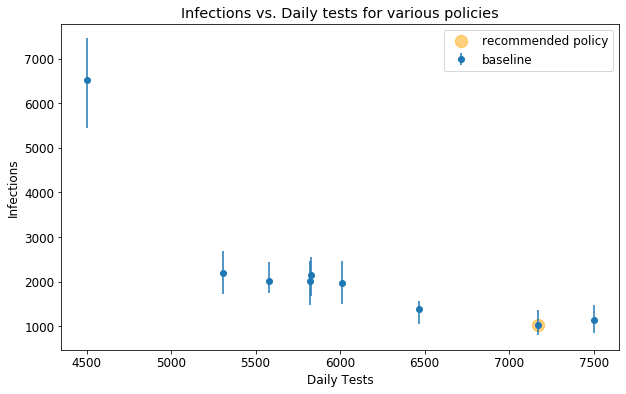

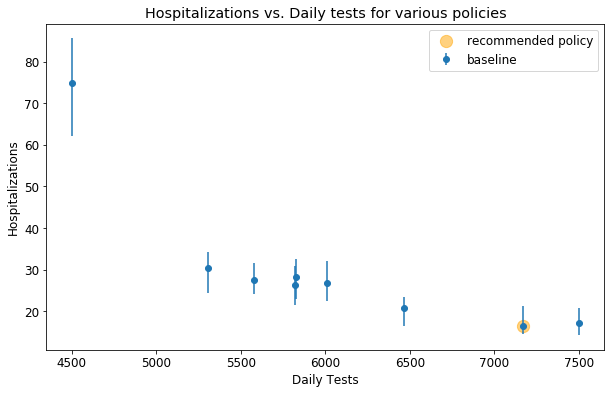

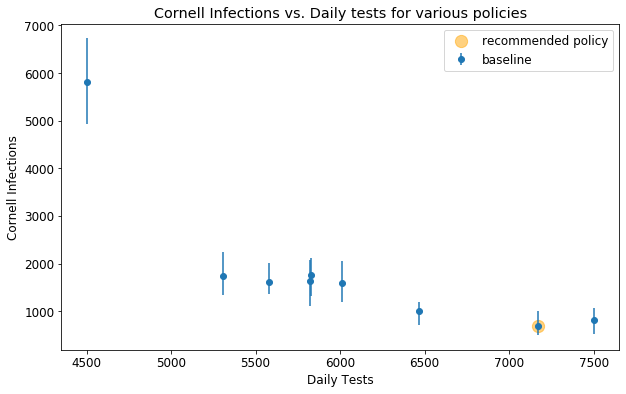

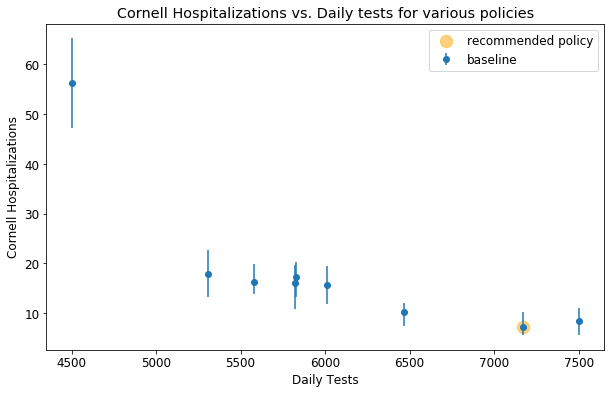

In [28]:
plot_policy_performance(plotting_data)

## Increasing contacts between faculty/staff and Ithaca even more

In [ ]:
interaction_matrix_v3 = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,4.5],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,4.5],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,4.5],
                               [0.011,0.026,0.106,0.016,0.261,0.138,0.347,3.5]])

results_faculty_ithaca_3x = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix_v3, group_names, policy, 112, 50)
    results_faculty_ithaca_3x.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]


## Increasing Student->Student contact rates by 30%

In [20]:
interaction_matrix_v4 = np.array([[16.25,5.2,0.1,0.1,1,0.05,0.05,0.1],
                               [4.43,10.4,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,11.7,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,4.5],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,4.5],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,4.5],
                               [0.011,0.026,0.106,0.016,0.261,0.138,0.347,3.5]])

results_students_30 = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix_v4, group_names, policy, 112, 50)
    results_students_30.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857